<a href="https://colab.research.google.com/github/DaniloRiver/Seminario-de-Investigacion-UNAH/blob/main/Modelo_de_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Seminario de** **Investigación**



In [1]:
#Librerias a Utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [12]:
# Cargando el Dataset Diabetes
url="https://raw.githubusercontent.com/DaniloRiver/Seminario-de-Investigacion-UNAH/main/diabetes.csv"
datos= pd.read_csv(url)
datos.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
#Estadisticos para el Dataset
datos.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
# Utilizando los primeros 200 registros de Diabetes.csv (Dimensiones)
Diabetes=datos[:200]
Diabetes.shape

(200, 9)

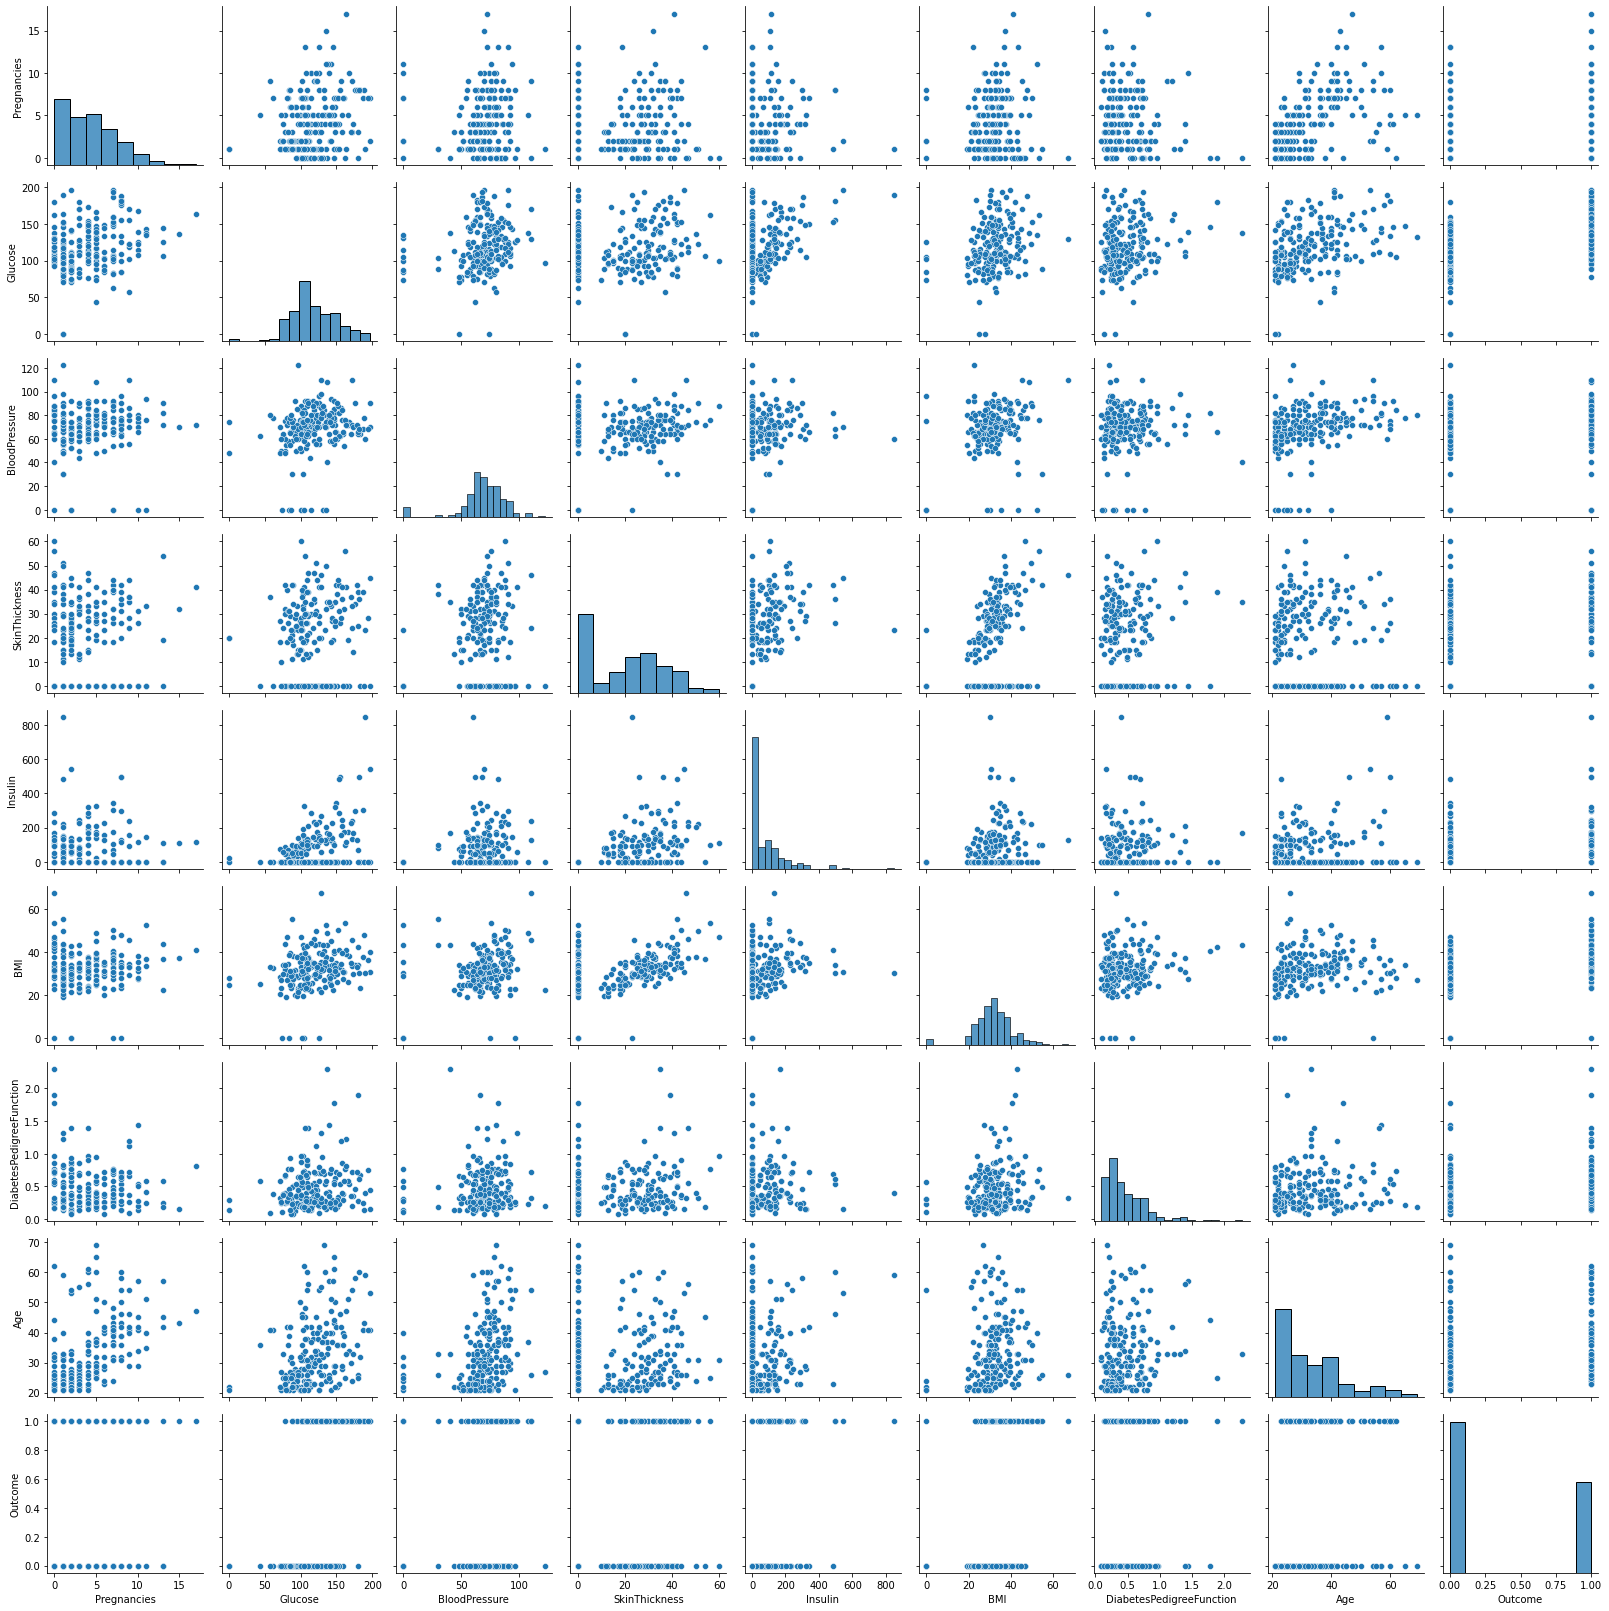

In [15]:
sns.pairplot(Diabetes)
plt.tight_layout()

In [16]:
# Preparando las variables X, y del modelo  X=Matriz de Predictores , y= variable de resultados  1: con diabetes , 0: sin diabetes
X=Diabetes[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
y=Diabetes.Outcome

In [17]:
#Verificacion de variables X
X[:3]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32


In [18]:
# verificacion de variable y
y[:5]

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [19]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 30% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= 0.30,random_state=0)

In [20]:
#  StandardScaler() normalizará las características (cada columna de X, INDIVIDUALMENTE !!!) 
#  para que cada columna/característica/variable tenga mean = 0 y standard deviation = 1.

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [21]:
# Aplicacion del algoritmo de regresion logistica y entrenamiento de las variables X_train,y_train

logreg =LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# coeficiente que corresponde a los coeficientes B (beta) que corresponden a los de la ecuacion de regresion logistica (pesos)
logreg.coef_


array([[ 0.34811702,  1.04423575, -0.27064413,  0.18832492, -0.14231465,
         0.28650901,  0.26616394,  0.27352958]])

In [23]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [24]:
#Matriz de confusion proporciona ,verdaderos positivos,verdaderos negativos,falso positivo,falsos negativos
Matriz_confusion= confusion_matrix(y_test,y_pred)
Matriz_confusion

array([[28,  7],
       [10, 15]])

Text(0.5, 257.44, 'Etiqueta Predicción')

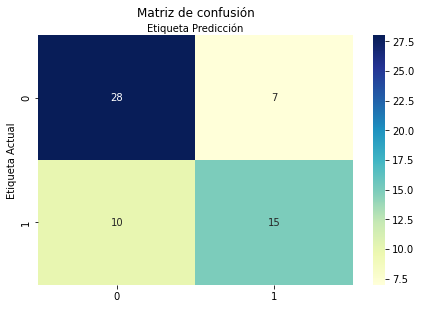

In [25]:
#Mapa de calor de la Matriz de confusion
nombre_clase=[0,1]
fig,ax= plt.subplots()
tick_marks=np.arange(len(nombre_clase))
plt.xticks(tick_marks,nombre_clase)
plt.yticks(tick_marks,nombre_clase)

sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title("Matriz de confusión",y=1.1)
plt.ylabel('Etiqueta Actual')
plt.xlabel('Etiqueta Predicción')

In [26]:
#Exactitud del modelo(porcentaje de predicciones correctas)
Exactitud= accuracy_score(y_test,y_pred)
print("Exactitud",Exactitud)

Exactitud 0.7166666666666667


In [27]:
#Tabla de variables 
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        38
           1       0.60      0.68      0.64        22

    accuracy                           0.72        60
   macro avg       0.70      0.71      0.70        60
weighted avg       0.73      0.72      0.72        60



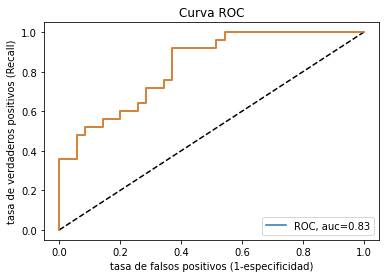

In [28]:
#Lo que estamos viendo es exactamente la curva ROC del clasificador. Y nos da bastante información: en primer lugar nos dice que aumentando o disminuyendo lo suficiente 
#el threshold podemos conseguir que nuestro algoritmo de clasificación alcance un TPR o un FPR casi perfecto.
#Cuando AUC es 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa. Esta es la peor situación.
#Cuando el AUC es aproximadamente 0.5, el modelo no tiene capacidad de discriminación para distinguir entre clase positiva y clase negativa.

y_pred_prob= logreg.predict_proba(X_test)[:,1]
fpr, tpr,tresholds= roc_curve(y_test,y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="ROC, auc="+str(round(auc,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr,tpr,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
plt.show()

Regresión Logística: f1=0.638 auc=0.793


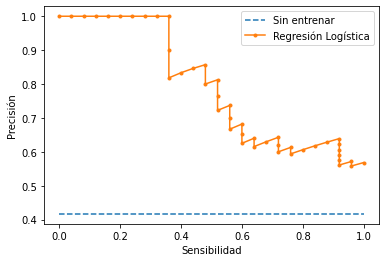

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predecimos probabilidades
y_pred_prob= logreg.predict_proba(X_test)[:,1]
# Sacamos los valores
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# Resumimos 
print('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# trazar las curvas de recuperación de precisión
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
#Etiquetas de ejes
pyplot.xlabel('Sensibilidad')
pyplot.ylabel('Precisión')

pyplot.legend()
pyplot.show()


